In [1]:
# reproducable randomness
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

c:\users\ck\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#### PyPi Modules

In [3]:
import tensorflow as tf
import numpy as np
from keras import backend as K
from IPython import display

Using TensorFlow backend.


In [4]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 15, 5

#### Local Modules

In [5]:
from neural_stylization.vgg19 import VGG_19
from neural_stylization._img_util import load_image, image_to_matrix, normalize, denormalize, matrix_to_image
from neural_stylization.jupyter_plot import JupyterPlot
from neural_stylization.loss_functions import content_loss, style_loss, total_variation_loss
from keras import backend as K

# Loading Images

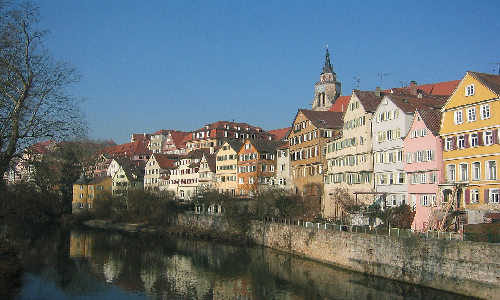

In [6]:
content = load_image('img/content/tubingen.jpg', (500, 300))
content

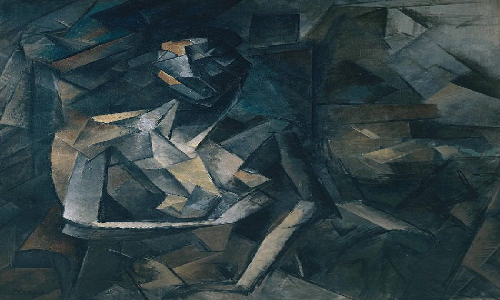

In [7]:
style = load_image('img/styles/seated-nude.jpg', (500, 300))
style

## Binary Image $\to$ 4D Tensor 

To process the image by the VGG model, we need it in a 4 dimensional
tensor of the shape schema $[frame, height, width, channel]$.

*   $frame$ indexes one of several frames passing through the network
*   $channel$ indexes the _color channel_.
    *   RGB $\implies$ 3
    *   Black and White $\implies$ 1

In [8]:
# convert the binary image data to a Numpy matrix
content = image_to_matrix(content)
style = image_to_matrix(style)

In [9]:
# normalize the image by the means in the ImageNet data
content = normalize(content)
style = normalize(style)

# Model

## Content

`block4_conv2`

## Style

`block1_conv1`, `block2_conv1`, `block3_conv1`, `block4_conv1`, `block5_conv1`

In [10]:
VGG_19(include_top=False).output_tensors

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/R

# Optimizing Loss

In [13]:
# the layer to use to extract the content representation
content_layer_name = 'block4_conv2'
# the layers to use to extract the style representation
style_layers_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
# the learning rate for the optimization task
learning_rate = 0.00001
# the number of iterations of optimization to perform
iterations = 2000
# the weighting factor alpha to apply to the content
content_weight = 1
# the weighting factor beta to apply to the style
style_weight = 15000
# the weighting of the total variation loss, this 
# controls how smooth the output image is
total_variation_weight = 35
# out put the ratio of alpha to beta
content_weight / style_weight

6.666666666666667e-05

> The ratio $α/β$ was either $1e−3$ (Fig 2 B,C,D) or $1e−4$ (Fig 2 E,F). 

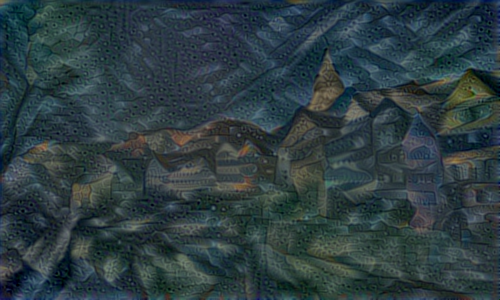

1999

In [14]:
# IMAGES
# load the content image into keras as a constant, it never changes
content_tensor = K.constant(content, name='Content')
# load the style image into keras as a constant, it never changes
style_tensor = K.constant(style, name='Style')
# create a placeholder for the trained image, this variable changes
canvas = K.placeholder(content.shape, name='Canvas')

# MODEL
# combine the content, style, and canvas tensors along the frame 
# axis (0) into a 4D tensor of shape [2, height, width, channels]
tensor = K.concatenate([content_tensor, style_tensor, canvas], axis=0)
# build the model with the input tensor of content, style, and canvas
model = VGG_19(include_top=False, input_tensor=tensor, pooling='avg')

# LOSSES
# initialize a variable to store the loss into
loss = K.variable(0.0, name='Loss')

# CONTENT LOSS
# extract the content layer tensor for optimizing content loss
content_layer_output = model[content_layer_name]
# calculate the loss between the output of the layer on the 
# content (0) and the canvas (2) 
loss += content_weight * content_loss(content_layer_output[0], content_layer_output[2])

# STYLE LOSS
# iterate over the list of all the layers that we want to include
for style_layer_name in style_layers_names:
    # extract the layer's out that we have interest in for reconstruction
    style_layer_output = model[style_layer_name]
    # calculate the loss between the output of the layer on the 
    # style (1) and the canvas (2). 
    style_loss_layer = style_loss(style_layer_output[1], style_layer_output[2])
    # Apply the lazy w_l factor of dividing by the size of the styling 
    # layer list. multiply the style weight in here
    loss += style_loss_layer * style_weight / len(style_layers_names)
    
# TOTAL VARIATION LOSS
# add the total variation loss based on the euclidean distance between shifted points
loss += total_variation_weight * total_variation_loss(canvas)
    
# GRADIENTS
# calculate the gradients of the input image with respect to 
# the loss. i.e. backpropagate the loss through the network 
# to the input layer (only the canvas though)
grads = K.gradients(loss, canvas)[0]

# generate the iteration function for gradient descent optimization
# Args:
#     noise: the input to the noise placeholder in the model
#         this effectively takes a the white noise image being
#         optimized and passes it forward and backward through 
#         the model collecting the loss and gradient along the 
#         way
# 
# Returns:
#     a tuple of (loss, gradients)
#     -   loss: the content loss between the content, style image
#         and the white noise
#     -   gradients: the gradients of the inputs with respect
#         to the loss
iterate = K.function([canvas], [loss, grads])

# generate random noise
noise = normalize(np.random.uniform(0, 128, content.shape))
# create a new interactive plot to visualize the loss in realtime
plot = JupyterPlot(title='Total Loss by Iteration', xlabel='Iteration', ylabel='Loss')
# perform the specified iterations of gradient descent
for i in range(iterations):
    # pass the noise the canvas tensor generating the loss
    # and gradients as a tuple
    loss_i, grads_i = iterate([noise])
    # move the noise based on the gradients and learning rate
    noise -= learning_rate * grads_i
    # update the plot with the loss for this iteration
#     plot(loss_i)
    display.clear_output(wait=True)
    display.display(matrix_to_image(denormalize(noise[0])))
    display.display(i)
    
# clear out all the keras variables from the GPU/CPU
K.clear_session()

# denormalize the image to add the mean values
# of the network back and flip the channels back
# to RGB from BGR. convert this RGB matrix to 
# an image we can look at
# matrix_to_image(denormalize(noise[0]))